In [4]:
from abc import abstractmethod
from tabicl.prior.dataset import SCMPrior
from tabicl.prior.prior_config import DEFAULT_FIXED_HP, DEFAULT_SAMPLED_HP

import numpy as np
from scipy.stats import loguniform
import joblib
import math

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nested import nested_tensor
from torch.utils.data import IterableDataset

from typing import Optional, Tuple, Dict, Any, Union

from mcpfn.prior.dataset import DummyPrior, MCARPrior
    
mcar_prior = MCARPrior(num_missing=10, max_features = 20, max_seq_len=100)

# X, _, _ = mcar_prior.generate_dataset({
#     'prior_type': 'mlp_scm',
#     'num_features': 10,
#     'num_classes': 2,
#     'device': 'cpu',
#     'seq_len': 20,
#     'train_size': 10,
#     'max_features': 20,
#     'min_features': 5,
#     'max_classes': 10,
#     'cat_prob': 1.0,
#     'scale_by_max_features': True,
#     'multiclass_type': 'rank',
#     'multiclass_ordered_prob': 0.2
# })

X, y, d, seq_lens, train_sizes = mcar_prior.get_batch(batch_size = 4)

print(X.shape)
print(seq_lens, train_sizes)

# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.heatmap(torch.isnan(X), cbar=False, cmap='Blues')

torch.Size([4, 2000, 118])
tensor([2000., 2000., 2000., 2000.]) tensor([1990., 1990., 1990., 1990.])


In [3]:
from mcpfn.model.layers import OneHotAndLinearBarDistribution
from mcpfn.model.bar_distribution import get_bucket_limits

embed = OneHotAndLinearBarDistribution(borders = get_bucket_limits(num_outputs = 100, ys = y[0]), embed_dim = 10)

In [62]:
from mcpfn.model.bar_distribution import FullSupportBarDistribution
from torch import Tensor
import torch.nn as nn

class OneHotAndLinear(nn.Linear):
    """Combines one-hot encoding and linear projection in a single efficient operation
    to convert categorical indices to embeddings.

    Parameters
    ----------
    num_classes : int
        Number of distinct categories for one-hot encoding

    embed_dim : int
        Output embedding dimension
    """

    def __init__(self, num_classes: int, embed_dim: int):
        super().__init__(num_classes, embed_dim)
        self.num_classes = num_classes
        self.embed_dim = embed_dim

    def forward(self, src: Tensor) -> Tensor:
        """Transform integer indices to dense embeddings.

        Parameters
        ----------
        src : Tensor
            Integer tensor of shape (batch_size, sequence_length) containing category indices

        Returns
        -------
        Tensor
            Embedded representation of shape (batch_size, sequence_length, embed_dim)
        """
        # Convert indices to one-hot vectors and apply linear projection
        one_hot = F.one_hot(src.long(), self.num_classes).to(torch.float32)
        return F.linear(one_hot, self.weight, self.bias)
    
class OneHotAndLinearBarDistribution(nn.Module):
    def __init__(self, borders: Tensor, embed_dim: int):
        super().__init__()
        self.bar_distribution = FullSupportBarDistribution(borders = borders)
        self.one_hot_and_linear = OneHotAndLinear(num_classes = len(borders) + 1, embed_dim = embed_dim)
        
    def forward(self, src: Tensor) -> Tensor:
        """Transform float values to dense embeddings using the BarDistribution.

        Parameters
        ----------
        src : Tensor
            Float tensor of shape (batch_size, sequence_length) containing values to embed

        Returns
        -------
        Tensor
            Embedded representation of shape (batch_size, sequence_length, embed_dim)
        """
        border_inds = self.bar_distribution.map_to_bucket_idx(src)
        return self.one_hot_and_linear(border_inds)

In [76]:
torch.arange(100 + 1).float() * 10_000

tensor([      0.,   10000.,   20000.,   30000.,   40000.,   50000.,   60000.,
          70000.,   80000.,   90000.,  100000.,  110000.,  120000.,  130000.,
         140000.,  150000.,  160000.,  170000.,  180000.,  190000.,  200000.,
         210000.,  220000.,  230000.,  240000.,  250000.,  260000.,  270000.,
         280000.,  290000.,  300000.,  310000.,  320000.,  330000.,  340000.,
         350000.,  360000.,  370000.,  380000.,  390000.,  400000.,  410000.,
         420000.,  430000.,  440000.,  450000.,  460000.,  470000.,  480000.,
         490000.,  500000.,  510000.,  520000.,  530000.,  540000.,  550000.,
         560000.,  570000.,  580000.,  590000.,  600000.,  610000.,  620000.,
         630000.,  640000.,  650000.,  660000.,  670000.,  680000.,  690000.,
         700000.,  710000.,  720000.,  730000.,  740000.,  750000.,  760000.,
         770000.,  780000.,  790000.,  800000.,  810000.,  820000.,  830000.,
         840000.,  850000.,  860000.,  870000.,  880000.,  89000

In [75]:
embed = OneHotAndLinearBarDistribution(borders = get_bucket_limits(num_outputs = 10, ys = y[0]), embed_dim = 5)
embed.forward(y)

tensor([[[ 0.3768,  0.4734,  0.3515,  0.1267,  0.1809],
         [ 0.0697, -0.0408,  0.0008, -0.0110,  0.3711],
         [ 0.0934,  0.2529, -0.1078,  0.3877,  0.1241],
         ...,
         [ 0.2729, -0.0564,  0.2694,  0.2176,  0.2458],
         [ 0.0697, -0.0408,  0.0008, -0.0110,  0.3711],
         [ 0.0286,  0.1849,  0.2529,  0.0896,  0.2210]],

        [[ 0.3768,  0.4734,  0.3515,  0.1267,  0.1809],
         [ 0.1820,  0.2355,  0.3742,  0.4739,  0.3579],
         [ 0.2617,  0.3889,  0.1455,  0.3633,  0.1481],
         ...,
         [ 0.2617,  0.3889,  0.1455,  0.3633,  0.1481],
         [ 0.2617,  0.3889,  0.1455,  0.3633,  0.1481],
         [ 0.3480,  0.0918,  0.2185,  0.4270,  0.5327]],

        [[ 0.3480,  0.0918,  0.2185,  0.4270,  0.5327],
         [ 0.2617,  0.3889,  0.1455,  0.3633,  0.1481],
         [-0.0122,  0.1016,  0.1509,  0.2821,  0.3547],
         ...,
         [ 0.3480,  0.0918,  0.2185,  0.4270,  0.5327],
         [ 0.2729, -0.0564,  0.2694,  0.2176,  0.2458],
  

In [19]:
y

torch.float32

In [20]:
embed.forward(y)

RuntimeError: Class values must be non-negative.

In [166]:
logits = torch.randn(4, 2000, 100)

In [57]:
torch.load('borders.pt')

tensor([-93.0867, -26.1321, -22.6323,  ...,  23.6954,  27.1553,  86.9426])

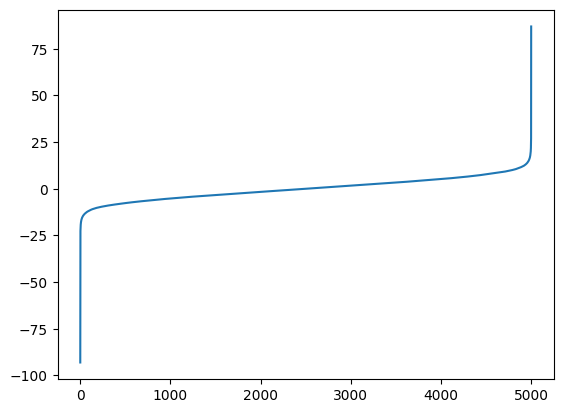

In [56]:
import torch

torch.load('borders.pt')

import matplotlib.pyplot as plt

plt.plot(torch.load('borders.pt'))

In [150]:
get_bucket_limits(num_outputs = 100, ys = y[0])

tensor([-3.8737e+00, -2.4309e+00, -2.0873e+00, -1.9186e+00, -1.7537e+00,
        -1.6525e+00, -1.5780e+00, -1.4858e+00, -1.3852e+00, -1.3385e+00,
        -1.2987e+00, -1.2466e+00, -1.2169e+00, -1.1501e+00, -1.0999e+00,
        -1.0378e+00, -1.0113e+00, -9.6897e-01, -9.2145e-01, -8.8394e-01,
        -8.4370e-01, -8.0649e-01, -7.7390e-01, -7.4602e-01, -7.1809e-01,
        -6.7251e-01, -6.4145e-01, -6.1843e-01, -5.9119e-01, -5.6030e-01,
        -5.3457e-01, -5.0215e-01, -4.7838e-01, -4.5791e-01, -4.3009e-01,
        -4.1545e-01, -3.8019e-01, -3.5528e-01, -3.3076e-01, -3.0420e-01,
        -2.7439e-01, -2.4172e-01, -2.2195e-01, -1.9647e-01, -1.7418e-01,
        -1.4726e-01, -1.2405e-01, -9.5777e-02, -7.5509e-02, -5.1924e-02,
        -3.1530e-02, -3.8033e-03,  1.9635e-02,  4.3842e-02,  7.4794e-02,
         9.6513e-02,  1.2021e-01,  1.6955e-01,  1.9146e-01,  2.2836e-01,
         2.6040e-01,  2.8865e-01,  3.1268e-01,  3.3820e-01,  3.6411e-01,
         3.8537e-01,  4.1810e-01,  4.4873e-01,  4.7

In [ ]:
# Now we just need to train on this data

In [151]:
import torch

batch1 = torch.load('/Users/jfeit/tabular/mcpfn/prior/batch_000000.pt')

In [154]:
batch1['X'].isnan().sum()

tensor(760)

In [48]:
batch1['X']

torch.Size([26227712])

In [46]:
batch1['y'].shape

torch.Size([512, 1024])

In [43]:
batch1['d']

tensor([ 13,  13,  13,  13,  36,  36,  36,  36,  37,  37,  37,  37,  47,  47,
         47,  47,  42,  42,  42,  42,  97,  97,  97,  97,  37,  37,  37,  37,
         75,  75,  75,  75,  43,  43,  43,  43,  70,  70,  70,  70,  73,  74,
         74,  74,  55,  55,  55,  55,  46,  46,  46,  46,  94,  94,  94,  94,
         18,  18,  18,  18,  60,  60,  60,  60,  44,  44,  44,  44,  83,  83,
         83,  83,  47,  47,  47,  47,  36,  36,  36,  36,  20,  20,  20,  20,
         30,  30,  30,  30,  43,  43,  43,  43,  61,  61,  61,  61,  33,  33,
         33,  33,   5,   5,   5,   5, 100, 100, 100, 100,  39,  39,  39,  39,
          4,   4,   4,   4,  79,  79,  79,  79,  97,  97,  97,  97,  80,  80,
         80,  80,  62,  62,  62,  62,  10,  10,  10,  10,  52,  52,  52,  52,
         82,  82,  82,  82,   8,   8,   8,   8,  58,  58,  58,  58,  78,  78,
         78,  78,  12,  12,  12,  12,  72,  72,  72,  72,  80,  80,  80,  80,
         97,  99,  99,  99,  29,  29,  29,  29,  55,  55,  55,  

In [6]:
from torch import nn
import torch.nn.functional as F

In [18]:
y_train = torch.randint(0, 10, (1, 1900))

one_hot = F.one_hot(y_train.long(), 10).to(torch.float32)

lin = nn.Linear(10, 512)

lin(one_hot)

tensor([[[-0.3267,  0.5456, -0.2666,  ...,  0.1564,  0.1221, -0.0616],
         [-0.3267,  0.5456, -0.2666,  ...,  0.1564,  0.1221, -0.0616],
         [-0.1359,  0.0529, -0.2173,  ..., -0.2137, -0.2599,  0.2424],
         ...,
         [-0.1359,  0.0529, -0.2173,  ..., -0.2137, -0.2599,  0.2424],
         [-0.0175,  0.3406, -0.1104,  ..., -0.1093,  0.2604,  0.2327],
         [-0.0101,  0.4443,  0.0548,  ...,  0.0775, -0.0382,  0.2546]]],
       grad_fn=<ViewBackward0>)

In [13]:
one_hot.shape

torch.Size([1, 1900, 10])

In [23]:
batch1 = torch.load('prior/batch_000000.pt')

In [37]:
batch1['X'].shape[0] / (4 * 2000)

20.0

In [33]:
batch1

{'X': tensor([ 1.4873,  0.9007, -2.1055,  ...,  0.5313,  2.5650,  0.4879]),
 'y': tensor([[ 1.9269,  1.4873,  0.9007,  ...,  0.3189,  0.7836,  0.3841],
         [-0.9928, -0.2558, -0.9586,  ...,  1.8776, -0.0146, -1.3936],
         [-2.4740,  1.3030, -0.5953,  ..., -1.1701, -0.3380, -1.2186],
         [-0.4628,  0.1498,  0.6902,  ...,  0.4652,  0.0260, -1.0705]]),
 'd': tensor([20, 20, 20, 20]),
 'seq_lens': tensor([2000., 2000., 2000., 2000.]),
 'train_sizes': tensor([1990., 1990., 1990., 1990.]),
 'batch_size': 4}

In [43]:
X = batch1['X'].reshape((4, 2000, 20))

In [47]:
X1 = X[0:1, :]

# Compute mean along dim=2 (last dimension), ignoring NaNs
mean_vals = torch.nanmean(X1, dim=2, keepdim=True)  # shape: [1, 2000, 1]

# Find the NaNs
nan_mask = torch.isnan(X1)  # shape: [1, 2000, 20]

# Expand mean_vals to match x's shape for indexing
mean_vals_expanded = mean_vals.expand_as(X1)

# Replace NaNs with corresponding mean values
X1[nan_mask] = mean_vals_expanded[nan_mask]

In [54]:
batch1['y'][0,1990:]

tensor([ 0.0186,  0.6454,  2.6221,  0.0877, -2.3692, -1.5197, -0.4666,  0.3189,
         0.7836,  0.3841])

In [48]:
X1.isnan().sum()

tensor(0)

In [22]:
y_train = torch.randn(1,1900)

y_train = y_train.unsqueeze(2)

lin = nn.Linear(1, 512)

lin(y_train)

torch.Size([1, 1900, 1])


tensor([[[ 0.3893,  1.0122, -0.0252,  ...,  0.0104,  0.6351,  0.7693],
         [ 0.4426,  0.9237,  0.0062,  ...,  0.0411,  0.7069,  0.7064],
         [ 0.3873,  1.0155, -0.0263,  ...,  0.0092,  0.6325,  0.7716],
         ...,
         [ 0.0725,  1.5377, -0.2118,  ..., -0.1722,  0.2090,  1.1428],
         [ 0.2951,  1.1684, -0.0807,  ..., -0.0439,  0.5084,  0.8803],
         [ 0.9194,  0.1325,  0.2872,  ...,  0.3160,  1.3485,  0.1440]]],
       grad_fn=<ViewBackward0>)

In [ ]:
# Load diabetes dataset
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

# Split into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from tabpfn import TabPFNRegressor

model = TabPFNRegressor(device="cpu")

model.fit(X_train, y_train)
model.bardist_.borders.shape

tensor([-93.0867, -26.1321, -22.6323,  ...,  23.6954,  27.1553,  86.9426])


/Users/jfeit/tabular/tabpfn/TabPFN/src/tabpfn/regressor.py:489: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(


tensor([-93.0867, -26.1321, -22.6323,  ...,  23.6954,  27.1553,  86.9426])

In [92]:
# load breast cancer dataset
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

# split into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = TabPFNClassifier()

model.fit(X_train, y_train)

/Users/jfeit/tabular/.venv/lib/python3.10/site-packages/tabpfn/classifier.py:432: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(


TabPFNClassifier()

In [2]:
model.bardist_.borders.shape

torch.Size([5001])

In [2]:
from tabpfn import TabPFNRegressor, TabPFNClassifier

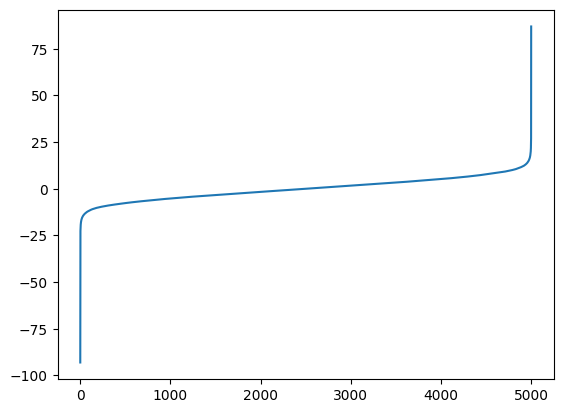

In [105]:
import matplotlib.pyplot as plt

plt.plot(model.bardist_.borders)

In [111]:
model = TabPFNRegressor()

In [112]:
model.__dict__

{'n_estimators': 8,
 'categorical_features_indices': None,
 'softmax_temperature': 0.9,
 'average_before_softmax': False,
 'model_path': 'auto',
 'device': 'auto',
 'ignore_pretraining_limits': False,
 'inference_precision': 'auto',
 'fit_mode': 'fit_preprocessors',
 'memory_saving_mode': 'auto',
 'random_state': 0,
 'n_jobs': -1,
 'inference_config': None}

In [110]:
from tabpfn import TabPFNRegressor

In [109]:
model.bardist_.borders

tensor([-93.0867, -26.1321, -22.6323,  ...,  23.6954,  27.1553,  86.9426])

In [29]:
import numpy as np

def create_train_test_sets(X):
    # Get missing indices in X
    missing_indices = np.where(np.isnan(X))
    
    non_missing_indices = np.where(~np.isnan(X))
    
    train_X = np.zeros((len(non_missing_indices[0]), X.shape[0] + X.shape[1] - 2))
    train_y = np.zeros(len(non_missing_indices[0]))
    test_X = np.zeros((len(missing_indices[0]), X.shape[0] + X.shape[1] - 2))
    test_y = np.zeros(len(missing_indices[0]))
    
    for k, (i,j) in enumerate(zip(non_missing_indices[0], non_missing_indices[1])):
        # Get row without j-th column
        row = np.delete(X[i,:], j)
        # Get column without i-th row
        col = np.delete(X[:,j], i)
        
        # Create train set
        train_X[k,:] = np.concatenate((row, col))
        train_y[k] = X[i,j]
        
    
    for k, (i,j) in enumerate(zip(missing_indices[0], missing_indices[1])):
        # Get row without j-th column
        row = np.delete(X[i,:], j)
        # Get column without i-th row
        col = np.delete(X[:,j], i)
        
        # Create train set
        test_X[k,:] = np.concatenate((row, col))
        test_y[k] = np.nan
        
    return train_X, train_y, test_X, test_y
    
X = np.array([[1, 3, 5], [7, np.nan, 6], [-1, 2, np.nan]])
train_X, train_y, test_X, test_y = create_train_test_sets(X)

print(train_X)
print(train_y)
print(test_X)
print(test_y)

[[ 3.  5.  7. -1.]
 [ 1.  5. nan  2.]
 [ 1.  3.  6. nan]
 [nan  6.  1. -1.]
 [ 7. nan  5. nan]
 [ 2. nan  1.  7.]
 [-1. nan  3. nan]]
[ 1.  3.  5.  7.  6. -1.  2.]
[[ 7.  6.  3.  2.]
 [-1.  2.  5.  6.]]
[nan nan]


In [19]:
import torch

In [20]:
X_tnsr = torch.from_numpy(X)

tensor([[ 1.,  3.,  5.],
        [ 7., nan,  6.],
        [-1.,  2., nan]], dtype=torch.float64)